# **AvStats - Flight Delay Forecast**

*Iraia Torres, October 2024*

### **Notebook 2 - Modeling and Predictions**
**Important Note**: *Run the EDA notebook before*

1. One hot encoding
2. Correlation Analysis
3. ML techniques
    * Standardization (Z-score)
    * Normalization (Min-Max Scaling)
    * Regularization (Lasso)
    * Multicollinearity (VIF)
4. Modelling
    * Linear Regression
    * Decision Tree
    * Random Forest
5. Hyperparameter Tuning
    * Grid Search CV
    * Randomized Search CV
6. Residual Analysis

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Add the base path to sys.path
BASE_DIR = Path().resolve().parent
sys.path.append(str(BASE_DIR / 'core'))

from core.flight_analysis_utils import *
from core.ML_workflow.DataPreparation import DataPreparation
from core.ML_workflow.Multicollinearity import Multicollinearity
from core.ML_workflow.ModelTraining import ModelTraining
from core.ML_workflow.ResidualAnalysis import ResidualAnalysis
from core.ML_workflow.ModelEvaluation import ModelEvaluation
from core.ML_workflow.ARIMA import TimeSeriesAnalysis, adf_test
from core.config import PARAM_GRID_RF

# Define the path to load the file
file_path = os.path.join("..", "data", "df_merged.csv")

# Load the DataFrame
df_merged = pd.read_csv(file_path)
print("DataFrame loaded successfully")

DataFrame loaded successfully


### **1. One hot encoding**

In [3]:
data_prep = DataPreparation(df_merged)

# Encode the routes and get the correlation dataframe
df_encoded, corr_df, route_columns = data_prep.encode_routes()

# Clean data by removing columns with only zeros
df_clean = data_prep.clean_data()

df_encoded

,Month,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,short_delay,...,BRU-TLS,BRU-TLV,BRU-TNG,BRU-TUN,BRU-VCE,BRU-VIE,BRU-VLC,BRU-WAW,BRU-YUL,BRU-ZRH
0,2023-01,42,21,21,18,21,3,1529.0,36,6,...,0,0,0,0,0,0,0,0,0,0
1,2023-02,35,19,16,14,19,2,1206.0,25,10,...,0,0,0,0,0,0,0,0,0,0
2,2023-03,46,22,24,17,22,7,1544.0,37,9,...,0,0,0,0,0,0,0,0,0,0
3,2023-04,37,18,19,15,18,4,1380.0,32,5,...,0,0,0,0,0,0,0,0,0,0
4,2023-05,39,18,21,17,18,2,1624.0,37,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2023-08,222,109,113,87,109,26,8083.0,165,57,...,0,0,0,0,0,0,0,0,0,2
752,2023-09,246,120,126,108,120,18,7941.0,177,69,...,0,0,0,0,0,0,0,0,0,2
753,2023-10,270,135,135,130,135,5,6782.0,170,100,...,0,0,0,0,0,0,0,0,0,2
754,2023-11,266,131,135,133,131,2,6157.0,158,108,...,0,0,0,0,0,0,0,0,0,2


### **2. Correlation Analysis**
Correlation analysis helps you understand the relationships between numerical variables. This can inform feature selection, detect multicollinearity, and reveal underlying patterns in your data.
* **Correlation Matrix** and **Heatmap**

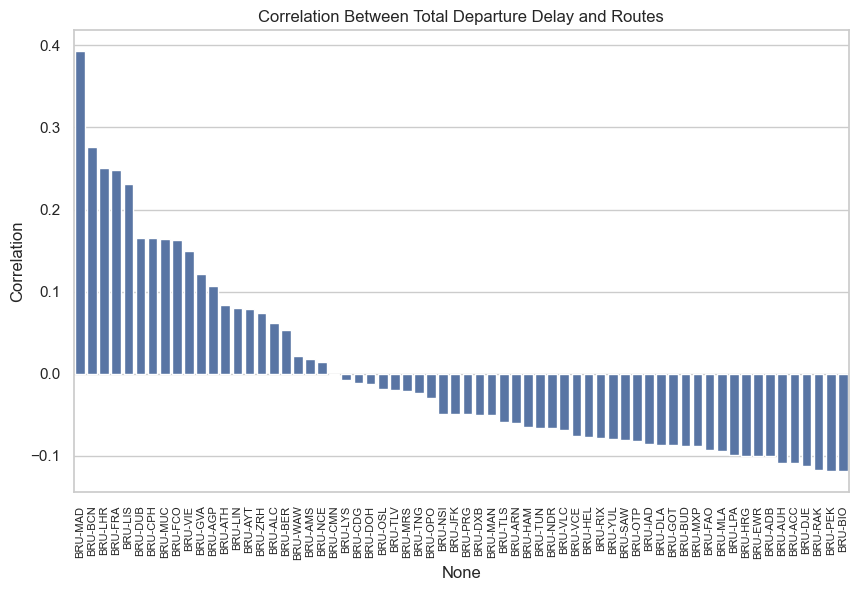

Routes showing the strongest positive correlation with Departure Delays:
 BRU-MAD    0.392701
BRU-BCN    0.275766
BRU-LHR    0.250346
BRU-FRA    0.248473
BRU-LIS    0.231481
Name: total_dep_delay_15, dtype: float64


In [4]:
# Calculate the correlation matrix
correlation_matrix = corr_df.corr()

# Extract only the correlation of 'total_dep_delay' with the routes
total_dep_delay_corr = correlation_matrix['total_dep_delay_15'][route_columns].sort_values(ascending=False)

# Filter for only positive correlations
positive_corr = total_dep_delay_corr[total_dep_delay_corr > 0.2]

# Plot the correlation between total_dep_delay and the route codes
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=total_dep_delay_corr.index, y=total_dep_delay_corr.values)
plt.xticks(rotation=90, fontsize=8)
plt.title('Correlation Between Total Departure Delay and Routes', fontsize=12)
plt.ylabel('Correlation')
plt.show()

# Print correlation values for better inspection
print('Routes showing the strongest positive correlation with Departure Delays:\n',positive_corr)

* **Positive correlation with delays**: More likely to experience delays. A high positive correlation indicates that delays are more frequent on that route.
* **Negative correlation with delays**: Less likely to be delayed. These routes tend to run on time, indicating more consistent operational conditions or favorable factors.

C:\Testing\Anaconda\envs\DTCS\lib\site-packages\pandas\core\groupby\grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)


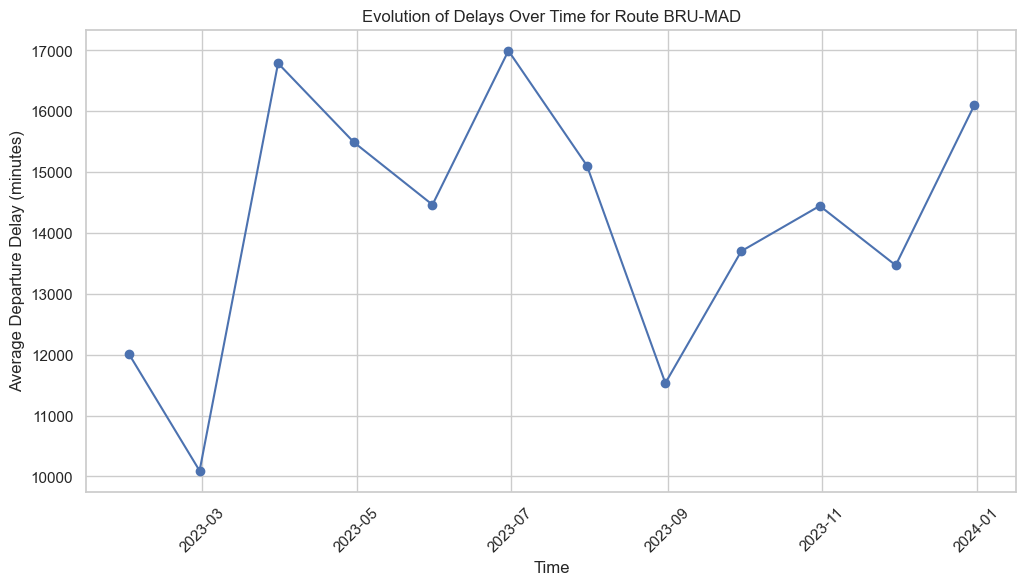

In [5]:
# Filter the dataframe for the specific route to analyze
route_code = 'BRU-MAD' 
df_route = df_merged[df_merged['route_iata_code'] == route_code]
df_route = df_route.infer_objects()

# Convert the 'Month' column to datetime if it's not already
df_route.loc[:, 'Month'] = pd.to_datetime(df_route['Month'])

# Resample the data to a monthly frequency, averaging only the numeric columns (e.g., dep_delay)
df_route_monthly = df_route.resample('ME', on='Month').mean(numeric_only=True)

# Plot the delay over time
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(df_route_monthly.index, df_route_monthly['total_dep_delay'], marker='o', linestyle='-')
plt.title(f'Evolution of Delays Over Time for Route {route_code}')
plt.xlabel('Time')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [6]:
# Get only the numeric columns
numeric_columns = df_clean.select_dtypes(include=['number']).columns.tolist()

# Print the list of numeric columns
print(numeric_columns)

['total_flights', 'departures', 'arrivals', 'landed', 'active', 'scheduled', 'total_dep_delay', 'total_dep_delay_15', 'short_delay', 'medium_delay', 'long_delay', 'total_calc_sft', 'total_calc_aft', 'total_flight_distance_km', 'commercial', 'private', 'cargo', 'morning_dep', 'afternoon_dep', 'evening_dep', 'morning_arr', 'afternoon_arr', 'evening_arr', 'total_on_time_15', 'avg_tavg_dep', 'total_prcp_dep', 'avg_wdir_dep', 'avg_wspd_dep', 'avg_wpgt_dep', 'avg_pres_dep', 'avg_tavg_arr', 'total_prcp_arr', 'avg_snow_arr', 'avg_wdir_arr', 'avg_wspd_arr', 'avg_wpgt_arr', 'avg_pres_arr', 'total_tsun_arr', 'total_passengers', 'BRU-ACC', 'BRU-ADB', 'BRU-AGP', 'BRU-ALC', 'BRU-AMS', 'BRU-ARN', 'BRU-ATH', 'BRU-AUH', 'BRU-AYT', 'BRU-BCN', 'BRU-BER', 'BRU-BIO', 'BRU-BUD', 'BRU-CDG', 'BRU-CMN', 'BRU-CPH', 'BRU-DJE', 'BRU-DLA', 'BRU-DOH', 'BRU-DUB', 'BRU-DXB', 'BRU-EWR', 'BRU-FAO', 'BRU-FCO', 'BRU-FRA', 'BRU-GOT', 'BRU-GVA', 'BRU-HAM', 'BRU-HEL', 'BRU-HRG', 'BRU-IAD', 'BRU-JFK', 'BRU-LHR', 'BRU-LIN', '

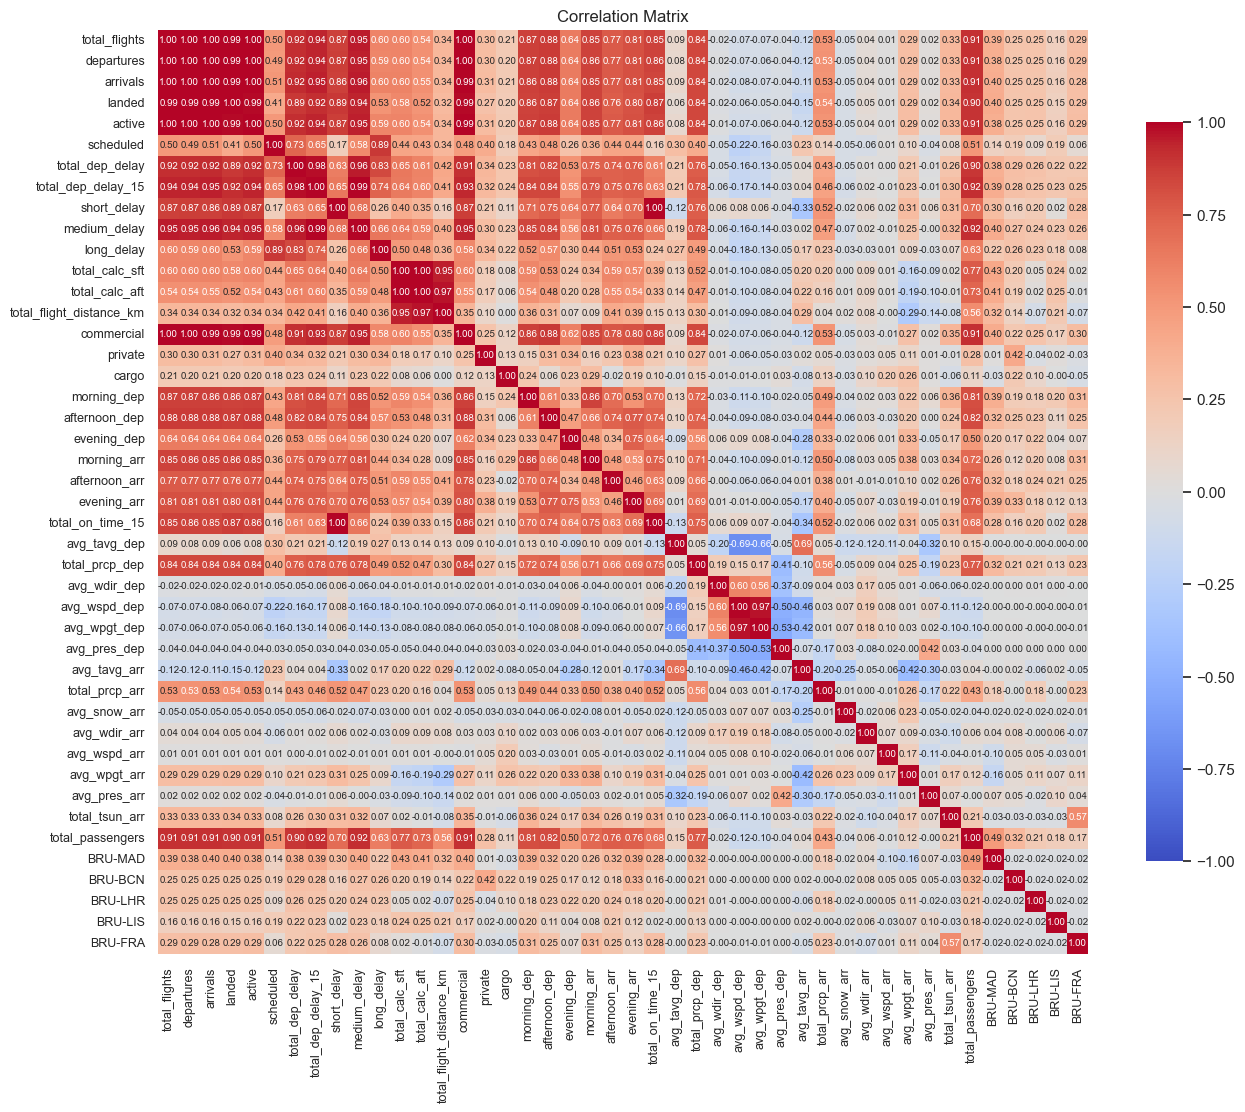

In [7]:
# Select the relevant columns for correlation analysis
corr_columns = ['total_flights', 'departures', 'arrivals', 'landed', 'active', 'scheduled', 'total_dep_delay', 'total_dep_delay_15', 'short_delay', 'medium_delay', 'long_delay', 'total_calc_sft', 'total_calc_aft', 'total_flight_distance_km', 'commercial', 'private', 'cargo', 'morning_dep', 'afternoon_dep', 'evening_dep', 'morning_arr', 'afternoon_arr', 'evening_arr', 'total_on_time_15', 'avg_tavg_dep', 'total_prcp_dep', 'avg_wdir_dep', 'avg_wspd_dep', 'avg_wpgt_dep', 'avg_pres_dep', 'avg_tavg_arr', 'total_prcp_arr', 'avg_snow_arr', 'avg_wdir_arr', 'avg_wspd_arr', 'avg_wpgt_arr', 'avg_pres_arr', 'total_tsun_arr', 'total_passengers', 'BRU-MAD', 'BRU-BCN', 'BRU-LHR', 'BRU-LIS', 'BRU-FRA']

corr_df = df_clean[corr_columns].dropna() # Drop any rows with NaN values
corr_df = corr_df.loc[:, (corr_df[corr_columns] != 0).any(axis=0)].dropna()
corr_df.reset_index(drop=True, inplace=True)  # Reset the index after dropping rows
correlation_matrix = corr_df.corr() # Perform the correlation analysis

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, 
            fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 7}, 
            cbar_kws={'shrink': 0.8})

# Set the font size for the axis labels
plt.xticks(fontsize=9)  # X-axis labels
plt.yticks(fontsize=9)  # Y-axis labels

# Title and adjustments
plt.title('Correlation Matrix', fontsize=12)
plt.show()

* The target variable should be kept in the DataFrame after the VIF process but excluded from the calculations when identifying features with high multicollinearity since the target variable is needed for the modeling stage.

### **3. Machine Learning Techniques - Data Preprocessing**

#### **3.1. Standardization - Z-score normalization**

**Purpose**: To scale features so that they have a mean of 0 and a standard deviation of 1, effectively transforming the data to a standard normal distribution.

**How it works**: The formula for standardization is:

    Xstd = (X − μ) / σ

where:

    X is the feature value,
    μ is the mean of the feature,
    σ is the standard deviation of the feature.

**When to use**:
* When the data follows a normal distribution (or approximately) or when  working with algorithms that assume data is normally distributed, like linear regression, logistic regression, or principal component analysis (PCA).
* It is less sensitive to outliers than normalization but still can be affected if there are extreme outliers.


In [8]:
# Standardize data
scaled_df, target_variable = data_prep.standardize_data()

# Check the mean and standard deviation
print("Means of scaled features:\n", scaled_df.mean())
print("Standard deviations of scaled features:\n", scaled_df.std())

Means of scaled features:
 total_flights   -1.080852e-16
departures      -1.409807e-17
arrivals         1.879743e-17
landed           7.518971e-17
active           4.934325e-17
                     ...     
BRU-VIE          9.398713e-18
BRU-VLC          9.398713e-18
BRU-WAW          9.398713e-18
BRU-YUL          9.398713e-18
BRU-ZRH         -2.819614e-17
Length: 102, dtype: float64
Standard deviations of scaled features:
 total_flights    1.000662
departures       1.000662
arrivals         1.000662
landed           1.000662
active           1.000662
                   ...   
BRU-VIE          1.000662
BRU-VLC          1.000662
BRU-WAW          1.000662
BRU-YUL          1.000662
BRU-ZRH          1.000662
Length: 102, dtype: float64


In [9]:
scaled_df

,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay_15,short_delay,medium_delay,long_delay,...,BRU-TLS,BRU-TLV,BRU-TNG,BRU-TUN,BRU-VCE,BRU-VIE,BRU-VLC,BRU-WAW,BRU-YUL,BRU-ZRH
0,-1.020906,-1.017989,-1.023053,-1.011953,-1.027484,-0.457786,-0.880541,-1.008000,-0.892910,-0.540922,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
1,-1.079034,-1.051632,-1.104999,-1.081155,-1.061006,-0.606705,-1.019600,-0.932334,-1.033415,-0.629551,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
2,-0.987690,-1.001168,-0.973885,-1.029254,-1.010723,0.137887,-0.867899,-0.951250,-0.892910,-0.452292,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
3,-1.062426,-1.068453,-1.055831,-1.063854,-1.077767,-0.308868,-0.931108,-1.026916,-0.921011,-0.718181,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
4,-1.045818,-1.068453,-1.023053,-1.029254,-1.077767,-0.606705,-0.867899,-1.083665,-0.906961,-0.363663,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,0.473826,0.462269,0.484764,0.181768,0.447464,2.967337,0.750244,-0.043263,0.413782,2.649743,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008
752,0.673124,0.647302,0.697825,0.545074,0.631832,1.775990,0.901945,0.183734,0.722892,1.763447,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008
753,0.872421,0.899619,0.845328,0.925681,0.883244,-0.159949,0.813453,0.770143,0.933649,-0.186403,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008
754,0.839205,0.832334,0.845328,0.977582,0.816201,-0.606705,0.661752,0.921475,0.765044,-0.186403,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008


* Means close to 0: The means are extremely close to zero, indicated by very small values like 7.518971e-17, which is essentially 0. This is expected after standardization.
* Standard Deviations close to 1: The standard deviations are approximately 1 (1.000662), which confirms that all features have been scaled to a unit standard deviation.

#### **3.2. Normalization? - Min-Max Scaling**
**Purpose**: To scale features so that they lie within a specific range, typically [0, 1] or [-1, 1].

**How it works**: The formula for normalization is:

    Xnorm = (X − Xmin) / (Xmax - Xmin)

where:

    X is the feature value,
    Xmin is the minimum value of the feature,
    Xmax is the maximum value of the feature.

**When to use**:
* To bound features to a specific range, especially if the model is sensitive to the magnitude of the input values, like neural networks or k-NN.
* It is sensitive to outliers, as the presence of extreme values can skew the results.

#### **3.3. Regularization - Lasso**
**Purpose**: To prevent overfitting by adding a penalty to the loss function of the model, effectively discouraging the model from becoming too complex.

**How it works**:
* **L1 regularization (Lasso)**: Adds a penalty term proportional to the absolute value of the coefficients. It can drive some coefficients to zero, effectively performing feature selection.
* **L2 regularization (Ridge)**: Adds a penalty term proportional to the square of the coefficients, encouraging smaller coefficients but not necessarily driving them to zero.
* **ElasticNet** combines both L1 and L2 penalties.

**When to use**:
* When the model is overfitting, meaning it performs well on training data but poorly on test data.
* It is used to constrain the complexity of a model, especially when there are too many features or when there’s a risk of multicollinearity.

Important features according to Lasso regression: total_flights         1835.317914
long_delay             762.094776
total_dep_delay_15     698.294238
medium_delay           185.436077
scheduled              161.289258
landed                 152.655544
morning_dep            132.465555
arrivals               132.316207
evening_arr            100.273685
avg_wpgt_dep            59.840061
cargo                  -74.643000
morning_arr            -81.543013
avg_wspd_dep          -104.673049
avg_wpgt_arr          -109.006059
total_on_time_15      -126.349644
short_delay           -518.292736
dtype: float64


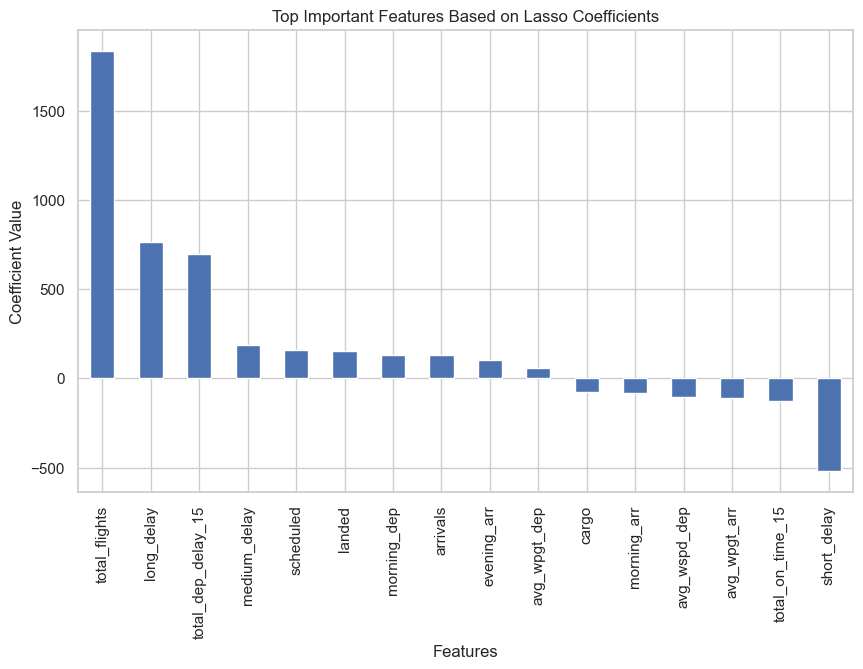

In [10]:
important_features_df, important_features = data_prep.select_important_features()

# The important features
print(f"Important features according to Lasso regression: {important_features}")

# Visualize the top 10 important features
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar')
plt.title('Top Important Features Based on Lasso Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

* The coefficient indicates the strength of the relationship between the feature and the target variable. 
* The higher the absolute value, the more influence that feature has on the target.
* Example **landed: 1600.493731**: This suggests that landed has a strong positive influence on the target variable (total_dep_delay). As the value of landed increases, the predicted value of total_dep_delay is likely to increase by approximately 1600 minutes.

#### **3.4. Multicollinearity - VIF**

In [11]:
# Initialize the Multicollinearity class
multicollinearity = Multicollinearity(scaled_df, target_variable, verbose=False) # False to suppress output

# Remove features with high VIF values
print("Removing high VIF features...")
df_vif_cleaned, final_features = multicollinearity.remove_high_vif_features()

Removing high VIF features...


C:\Testing\Anaconda\envs\DTCS\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


All remaining features have VIF below the threshold.
Final VIF values after feature removal:
                      feature   VIF
0                  scheduled  1.73
1   total_flight_distance_km  2.20
2           total_on_time_15  4.13
3               avg_tavg_dep  4.77
4             total_prcp_dep  6.81
5               avg_wdir_dep  1.64
6               avg_wpgt_dep  5.38
7               avg_pres_dep  3.47
8               avg_tavg_arr  3.49
9             total_prcp_arr  1.69
10              avg_snow_arr  1.20
11              avg_wdir_arr  1.11
12              avg_wspd_arr  1.09
13              avg_wpgt_arr  1.81
14              avg_pres_arr  1.60
15            total_tsun_arr  1.20
16          total_passengers  5.77


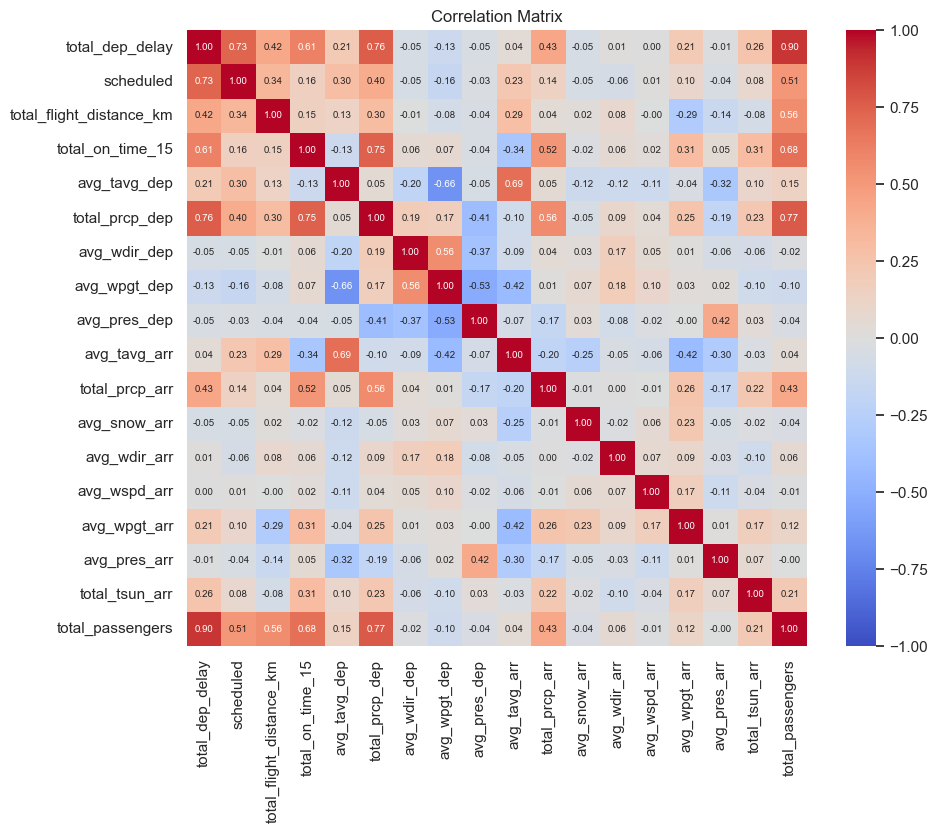

In [12]:
correlation_matrix = df_vif_cleaned.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 7}) 
plt.title('Correlation Matrix')
plt.show()

### **4. Modelling & Predicting**
First, linear regression will be used since it provides a **quick initial understanding** of the relationship between the predictors (independent) and the target variable (dependent). It's useful to detect **multicollinearity** (correlation between features) and to see if a **simple model** is enough to get good results before moving to complex ones, such as Random Forest.

In [13]:
# Split the data into features (X) and target (y)
x = df_vif_cleaned.drop(columns=['total_dep_delay'])  # drop the target variable
y = df_vif_cleaned['total_dep_delay']

# Training and testing data based on features
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model_training = ModelTraining(x_train, y_train, x_test, y_test)

#### **4.1. Linear Regression**
* **Dep. Variable**. The dependent variable we want to predict (it's total_dep_delay).
* **Model**. The type of model used, which is OLS (Ordinary Least Squares).
* **Method**. Least Squares, which is the standard approach for fitting a linear regression model.
* **No. Observations**. There are 604 data points (rows) in the dataset.
* **Df Residuals**. The degrees of freedom for residuals (observations minus the number of estimated parameters). Here, it's 586.
* **Df Model**. The degrees of freedom for the model (the number of predictors), which is 17 (including the intercept).

                            OLS Regression Results                            
Dep. Variable:        total_dep_delay   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     473.0
Date:                Fri, 22 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:28:21   Log-Likelihood:                -4939.6
No. Observations:                 604   AIC:                             9915.
Df Residuals:                     586   BIC:                             9995.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

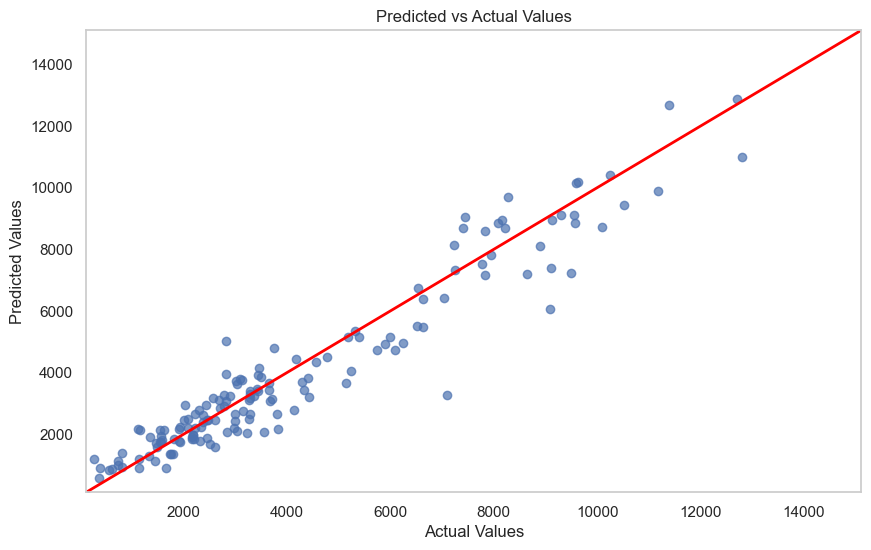

Model Evaluation: {'MAE': '620.77', 'MSE': '713835.89', 'R2': '0.92'}
Cross Validation: [0.91228487 0.93188671 0.91204794 0.93207209 0.93185602]


In [14]:
# Train a Linear Regression model and generate predictions
linear_model, linear_predictions = model_training.train_linear_model()
print(linear_model.summary())

# Plot results
model_training.plot_model()

# Model Evaluation
linear_evaluation = ModelEvaluation(linear_model, linear_predictions, x_train, y_train, x_test, y_test)
linear_metrics = linear_evaluation.evaluate_model()
print("Model Evaluation:", linear_metrics)

# Cross-validation (scores for each fold in a 5-fold cross-validation)
linear_cv = linear_evaluation.cross_validate()
print("Cross Validation:", linear_cv)

#### **4.2. Decision Tree**

#### **4.3. Random Forest**

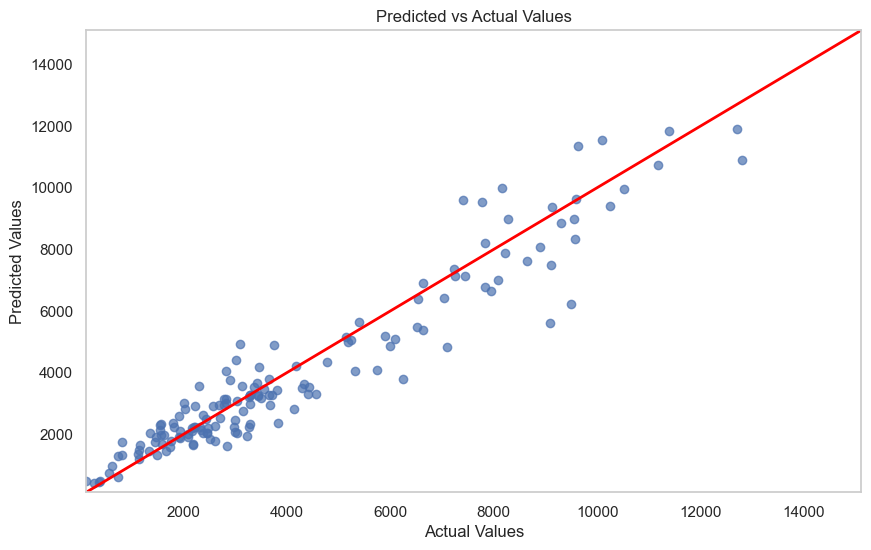

Model Evaluation: {'MAE': '633.29', 'MSE': '774889.89', 'R2': '0.92'}
Cross Validation: [0.91228487 0.93188671 0.91204794 0.93207209 0.93185602]


In [15]:
# Train a Random Forest model
random_forest_model, random_forest_predictions = model_training.train_random_forest()

# Plot the model results
model_training.plot_model()

# Model Evaluation
random_forest_evaluation = ModelEvaluation(random_forest_model, random_forest_predictions, x_train, y_train, x_test, y_test)
random_forest_metrics = random_forest_evaluation.evaluate_model()
print("Model Evaluation:", random_forest_metrics)

# Cross-validation (scores for each fold in a 5-fold cross-validation)
random_forest_cv = random_forest_evaluation.cross_validate()
print("Cross Validation:", random_forest_cv)

### **5. Hyperparameter Tuning**
* RandomForestRegressor
* Hyperparameter Tuning: Helps to identify the best combination of hyperparameters that optimize model performance. 
    * **Grid Search CV**. Tests all combinations.
    * **Randomized Search CV**. Tests random samples.

#### **5.1. Grid Search**

**Candidates**. It systematically tries every possible combination of the parameters in the provided param_grid. Since param_grid_rf has four hyperparameters:
            
        n_estimators: 3 options
        max_depth: 4 options
        min_samples_split: 3 options
        min_samples_leaf: 3 options

There are *3 x 4 x 3 x 3 = 108* possible combinations.

**Total Fits**. With 5-fold cross-validation (cv=5), Grid Search will evaluate each of the combinations 5 times, leading to a total of *108 x 5 = 540* fits.

In [15]:
# Perform Grid Search and evaluate
grid_tuning_model, grid_tuning_parameters, grid_predictions, sample_sizes, grid_train_errors, grid_test_errors = model_training.tune_and_evaluate(
    param_grid=PARAM_GRID_RF,
    verbose=0,
    search_type='grid',
    log_scale=True  # Use log scale for sample sizes
)

print(f"Best Parameters Grid Search: {grid_tuning_parameters}")

# Model Evaluation
grid_evaluation = ModelEvaluation(grid_tuning_model, grid_predictions, x_train, y_train, x_test, y_test)
grid_metrics = grid_evaluation.evaluate_model()
print("Model Evaluation:", grid_metrics)

Best Parameters Grid Search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Model Evaluation: {'MAE': '630.84', 'MSE': '771226.10', 'R2': '0.92'}


#### **5.2. Random Search**

**Candidates**. Randomized Search doesn’t try all combinations but instead samples a subset from the provided parameter space. In this case:

        n_iter = 10
        
Meaning it will randomly sample *10 different* combinations from the parameter grid.

**Total Fits**. With 5-fold cross-validation, Randomized Search will evaluate each of the combinations 5 times, resulting in *10 x 5 = 50* total fits.

In [16]:
random_tuning_model, random_tuning_parameters, random_predictions, random_sample_sizes, random_grid_train_errors, random_grid_test_errors = model_training.tune_and_evaluate(
    param_grid=PARAM_GRID_RF,
    verbose=0,
    search_type='random',
    n_iter=10
)

print(f"Best Parameters Random Search: {random_tuning_parameters}")

# Model Evaluation
random_evaluation = ModelEvaluation(random_tuning_model, random_predictions, x_train, y_train, x_test, y_test)
random_metrics = random_evaluation.evaluate_model()
print("Model Evaluation:", random_metrics)

Best Parameters Random Search: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30}
Model Evaluation: {'MAE': '634.60', 'MSE': '768351.69', 'R2': '0.92'}


#### **5.3. Pareto Front Learning Curve (Grid Search)**

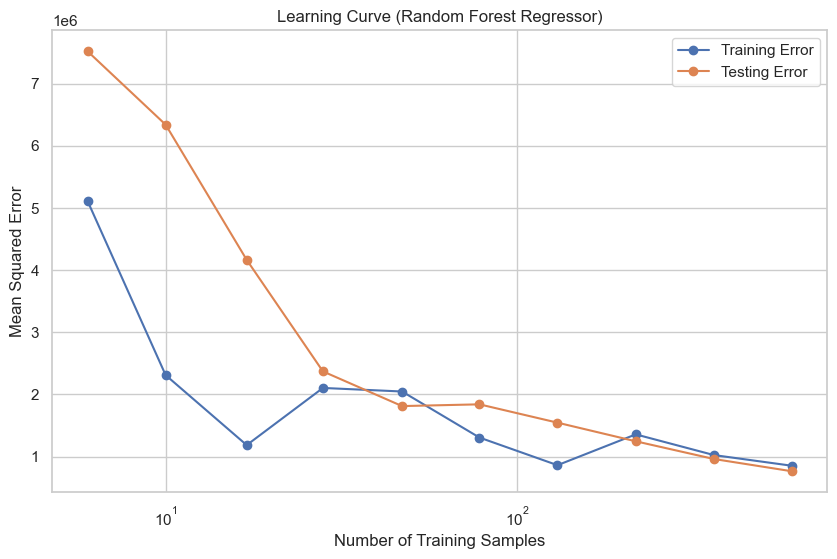

In [17]:
# Plotting the Learning Curve
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, grid_train_errors, label="Training Error", marker='o')
plt.plot(sample_sizes, grid_test_errors, label="Testing Error", marker='o')
plt.title(f"Learning Curve (Random Forest Regressor)")
plt.xlabel("Number of Training Samples")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()

### **6. ARIMA**
ARIMA (AutoRegressive Integrated Moving Average) is a statistical model suited for time series data. If the dataset has time-related features (like delays or flight frequencies over time), ARIMA can be used to predict future values.
* **Prepare Time Series Data**: Ensure the data is sorted by time. Create a dataset with a single time-dependent feature (e.g., delays, flight counts).
* **Build ARIMA Model**: Fit the model by using statsmodels.
    * p = 1 AutoRegressive part
    * d = 1 Differencing
    * q = 0 Moving Average part

#### **6.1. Choosing d (Differencing)**

It's used to make the time series stationary by for example, removing trends and seasonality. 
* Check stationarity with a Dickey-Fuller test. 
    * If the p-value is less than 0.05, the data is likely stationary. (d = 0)
    * If the test result indicates non-stationarity, apply differencing. (d = 1) or (d = 2)
* Determine d:
    * First trying d = 1 (first difference), which is common for time series with a trend.
    * If the data still shows a trend, try d = 2 (second difference), though higher differencing values are rare.

In [27]:
df_arima = df_encoded.copy()
df_arima = df_arima[:12]

arima_analysis = TimeSeriesAnalysis(df_arima, column='total_dep_delay', date_column='Month')
differenced_data, is_stationary = arima_analysis.check_stationarity()

if is_stationary:
    print("The data is stationary and ready for modeling.")
else:
    print("The data is still non-stationary after differencing.")

- ADF Test p-value (original): 0.09836594821085998
- ADF Test p-value (after 1 differencing): 5.65117919015219e-05
 
Series is stationary after 1 differencing -> d = 1.
The data is stationary and ready for modeling.


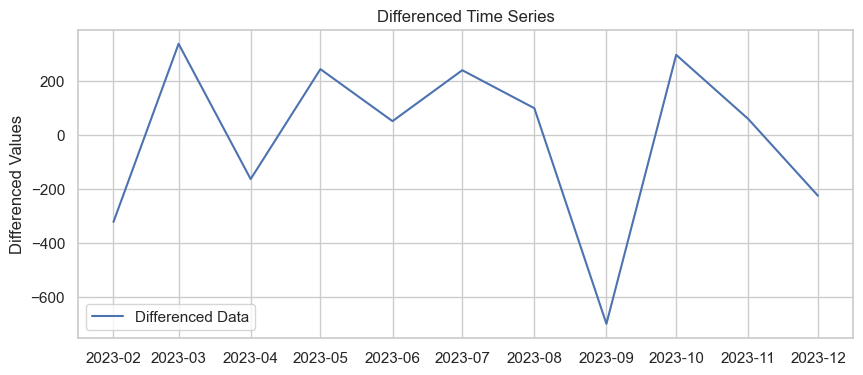

In [32]:
plt.figure(figsize=(10, 4))
plt.plot(differenced_data, label='Differenced Data')
plt.title("Differenced Time Series")
plt.ylabel("Differenced Values")
plt.legend()
plt.show()


#### **6.2. Choosing p (AR Order) and q (MA Order)**

The best practice is to start with a small p and q, and gradually increase them.

**Autoregressive (AR) order (p).**
* AR it's the relationship between the current observation and previous observations.
* This can be determined by analyzing the Partial Autocorrelation Function (PACF) plot.
    * If the PACF plot cuts off at some lag, this could be an estimation for p. (p = cutoff lag at PACF)

**Moving Average (MA) order (q).**
* MA  it's the relationship between the current observation and the residual errors from previous time steps.
* This can be determined by analyzing the Autocorrelation Function (ACF) plot.
    * If the ACF plot cuts off at a certain lag, it suggests that lag as the possible q. (q = cutoff lag at ACF)

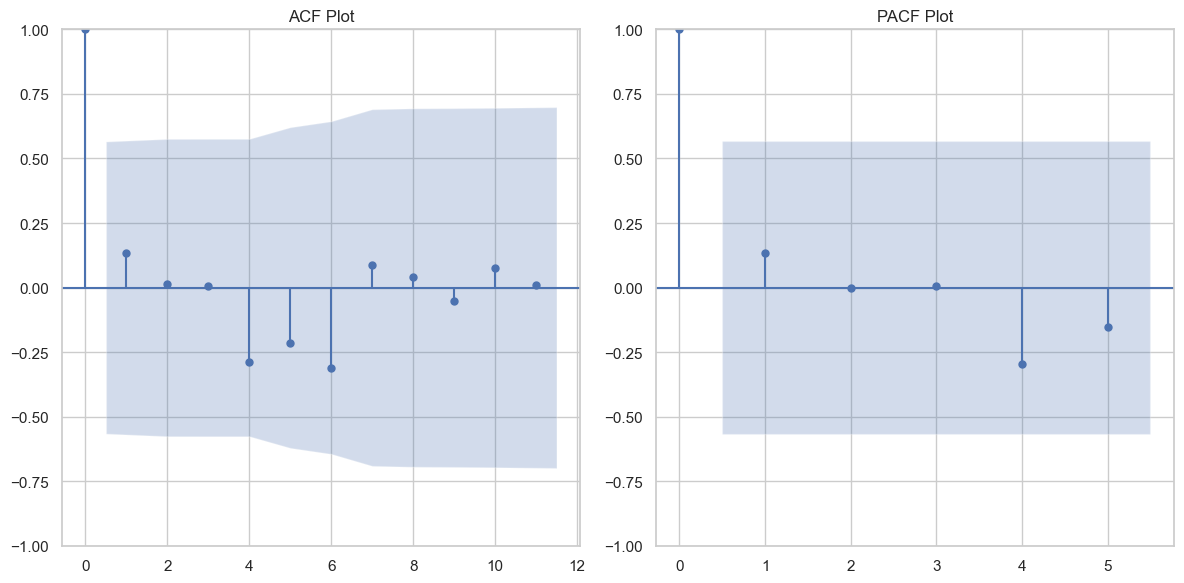

In [25]:
arima_analysis.plot_acf_pacf(11 ,5) # pacf lags need to be less than half of the total observations (12)
plt.show()

ACF Plot: This plot shows the correlation between the series and its lags.
* The cutoff point indicates the value for q, the order of the MA term (Moving Average). Where the autocorrelation becomes negligible (near zero). 
* If the ACF decays slowly, this suggests a higher order for q. If it cuts off sharply after a few lags, ysuggests a lower order for q.

PACF Plot: This plot shows the partial correlation of the series with its lags, controlling for the effect of earlier lags.
* Look for the cutoff point in the PACF plot. The lag where the PACF cuts off suggests the AR order (p).
* If the PACF cuts off after lag k, this suggests that p = k (i.e., the AR model only needs k previous values).
* If the PACF decays gradually, you may need a higher order for p.

#### **6.3. Fitting the ARIMA Model**

C:\Testing\Anaconda\envs\DTCS\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:        total_dep_delay   No. Observations:                   12
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 -75.225
Date:                Fri, 22 Nov 2024   AIC                            164.450
Time:                        15:35:38   BIC                            167.235
Sample:                    01-01-2023   HQIC                           162.694
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1447      1.825     -0.627      0.531      -4.722       2.433
ar.L2         -0.1719      2.100     -0.082      0.935      -4.289       3.945
ar.L3          0.4510      1.090      0.414      0.6

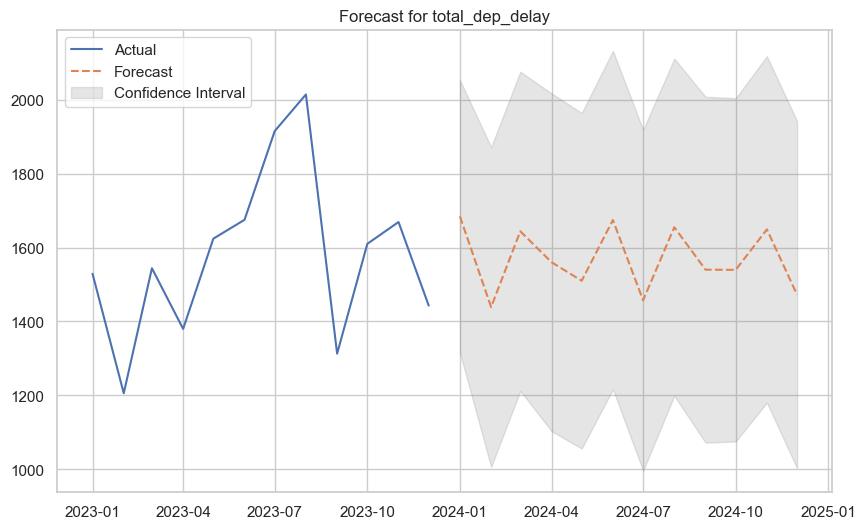

In [26]:
arima_model = arima_analysis.fit_arima(order=(3, 1, 3))
print(arima_model.summary())
arima_analysis.plot_forecast(steps=12)

### **7. Residual Analysis**
* **Calculate residuals**: The differences between the actual and predicted values.
* **Linearity**: They should show no clear pattern when plotted against fitted values.
* **Normality**: They should follow a normal distribution (with Q-Q plot or histogram).
* **Autocorrelation**: They should not show autocorrelation (check with Durbin-Watson or ACF).
* **Homoscedasticity**: They should have constant variance (no funnel shapes).

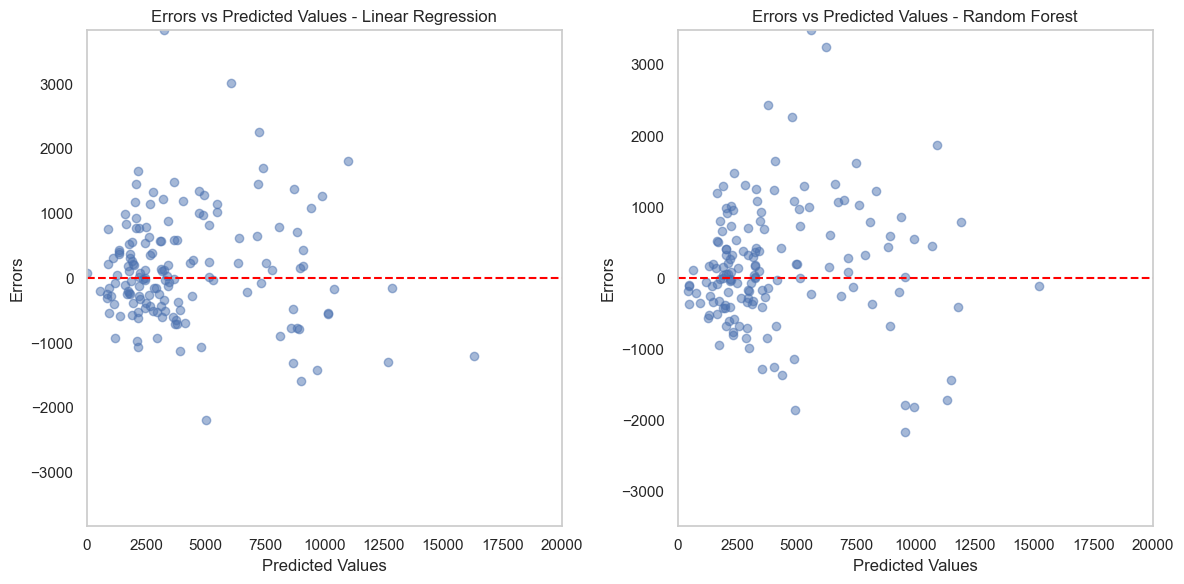

In [18]:
plt.figure(figsize=(12, 6))  

# Linear Regression - Residual Analysis
linear_residuals = ResidualAnalysis(linear_model, linear_predictions, x_test, y_test)
linear_residuals.plot_residuals("Linear Regression", subplot_position=(1, 2, 1))

# Random Forest - Residual Analysis
random_forest_residuals = ResidualAnalysis(random_forest_model, random_forest_predictions, x_test, y_test)
random_forest_residuals.plot_residuals("Random Forest", subplot_position=(1, 2, 2))

plt.tight_layout()
plt.show()

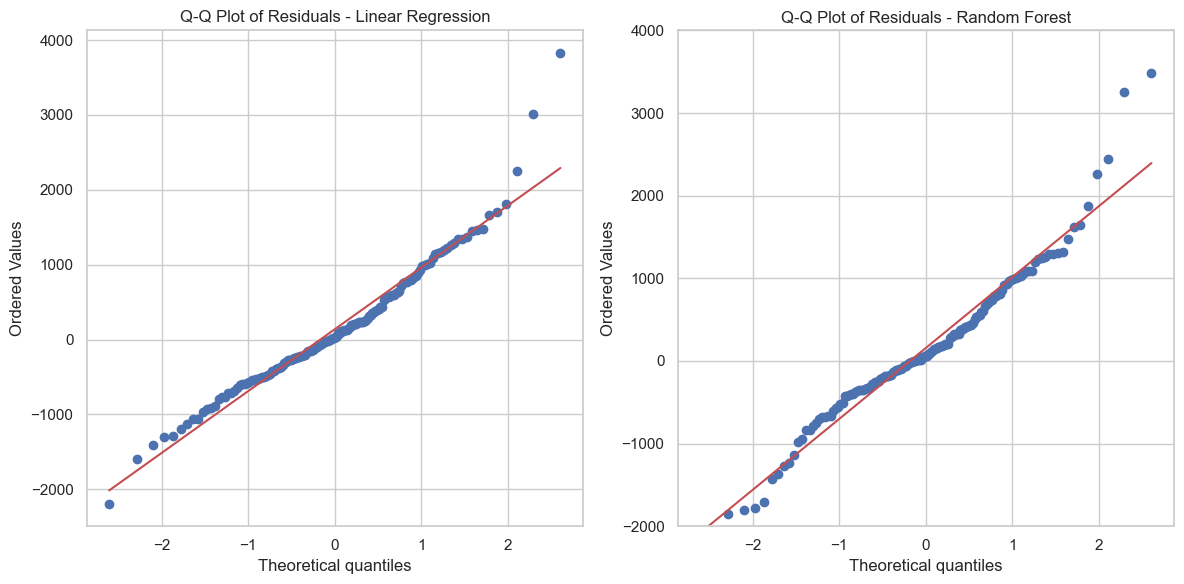

In [19]:
plt.figure(figsize=(12, 6))

linear_residuals.q_q_normality("Linear Regression", subplot_position=(1, 2, 1))
random_forest_residuals.q_q_normality("Random Forest", subplot_position=(1, 2, 2))

plt.tight_layout()
plt.ylim(-2000, 4000)
plt.show()

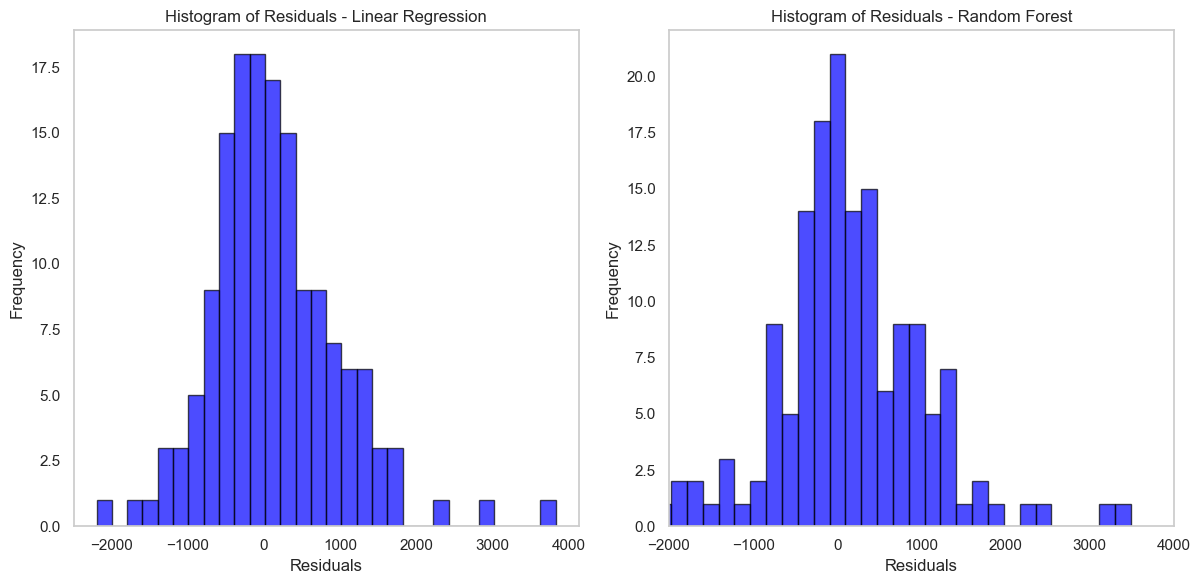

In [20]:
plt.figure(figsize=(12, 6))

linear_residuals.histogram_normality("Linear Regression", subplot_position=(1, 2, 1))
random_forest_residuals.histogram_normality("Random Forest", subplot_position=(1, 2, 2))

plt.tight_layout()
plt.xlim(-2000, 4000) 
plt.show()

### **(from here, it needs to be updated)**
* Boxplot of the current model to **find outliers**
* **Remove** them (values above 12000)
* **Log transformation** to reduce skewness and make the distribution more normal
* Box plot to visualize any **remaining outliers**
* **Histogram** to visualize current the distribution
* Check the **model without outliers**

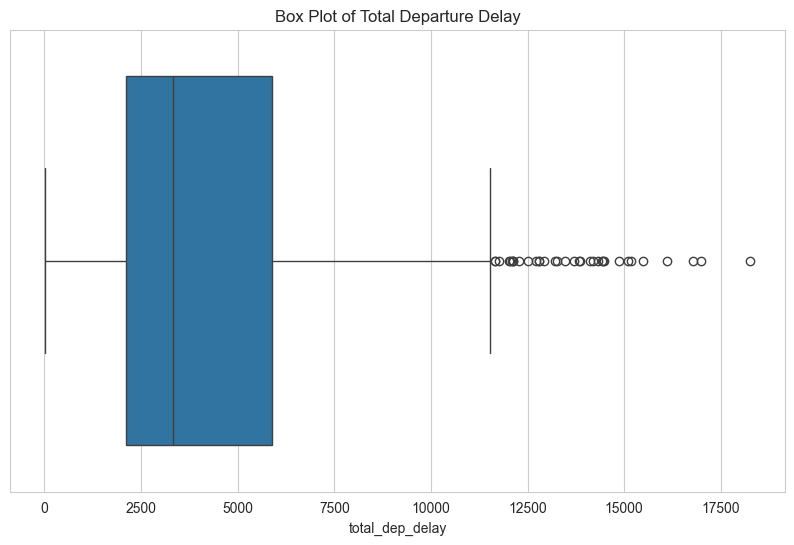

In [13]:
# Box plot to identify outliers in the target variable
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_clean['total_dep_delay'])  # Replace with your target variable
plt.title('Box Plot of Total Departure Delay')
plt.show()

* The solid line in the box indicates the **median**
* The dashed line shows the **mean**
* Points that are further away from the max are considered **extreme values** (outliers)

Q1 and Q3 values show that 50% of the data lies within 3500 min. (from just under 2500 to around 6000), indicating that most flights have relatively small delays.

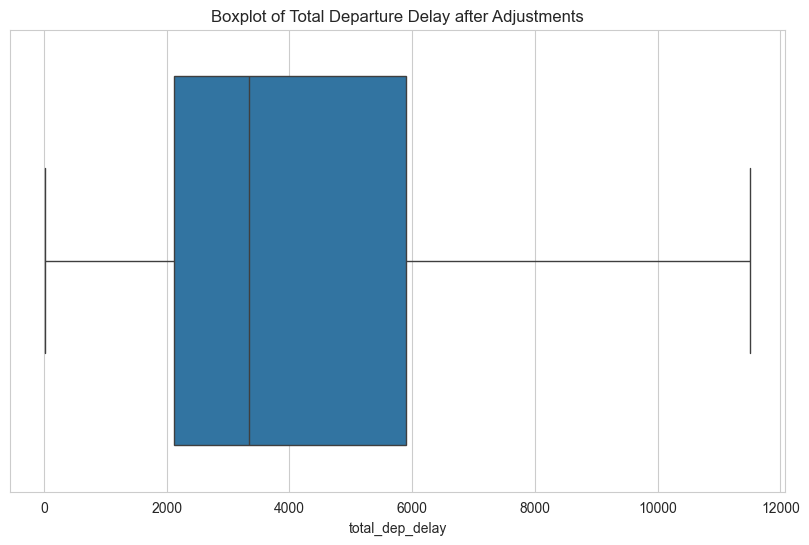

In [14]:
df_after_adj = df_clean.copy() # Copy of the dataframe to avoid warning

df_after_adj['total_dep_delay'] = df_after_adj['total_dep_delay'].clip(upper=11500) # Cap the outliers at 12000
df_after_adj['log_total_dep_delay'] = np.log1p(df_after_adj['total_dep_delay']) # Log transformation of the total departure delay

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_after_adj['total_dep_delay'])
plt.title('Boxplot of Total Departure Delay after Adjustments')
plt.show()

**Log transformation (Y=log(X))** is used to stabilize variance, reduce skewness, and make data more normally distributed. By transforming the data, we might find that the relationship between variables becomes linear, allowing for more straightforward modeling techniques.

When used with a variable (e.g., the target variable with the delay times), the range of **values are compressed**, mainly the larger ones. The model will predict values in the transformed scale (log scale). To visualize the predictions in their original scale, an exponential function will be used. 
$OriginalPredictions = e^{PredictionsLog}$

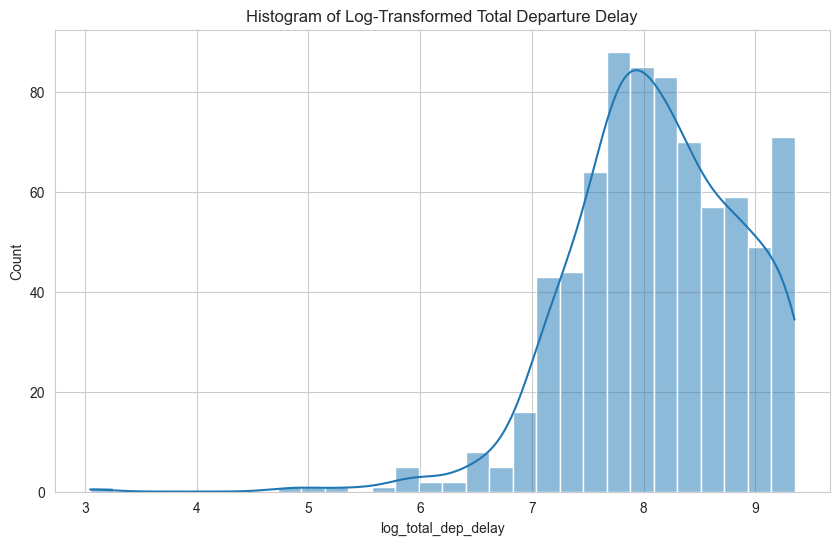

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df_after_adj['log_total_dep_delay'], bins=30, kde=True)
plt.title('Histogram of Log-Transformed Total Departure Delay')
plt.show()

* Compare the two models (with and without outliers), to compare their performance. **Random Forest** will be used for this.
    * n_estimators=200 (Number of trees in the forest): This parameter specifies the number of trees in the forest. In this case, the model will build 200 decision trees, and the final prediction will be an average of the predictions from all these trees (in a regression task). A higher number of estimators generally improves performance but increases computational cost.
    * random_state=42 (Seed for reproducibility): This parameter sets the seed for the random number generator. Setting a fixed seed like 42 ensures that the random processes within the model (e.g., data sampling for each tree, random feature selection) produce the same results each time the code is run. This helps with reproducibility—if you run the code multiple times, you'll get consistent results.

* Scattered residuals far from the red line mean the model struggles with some parts of the data.
* Tightly clustered residuals around the red line (y = 0) indicate a good model fit.

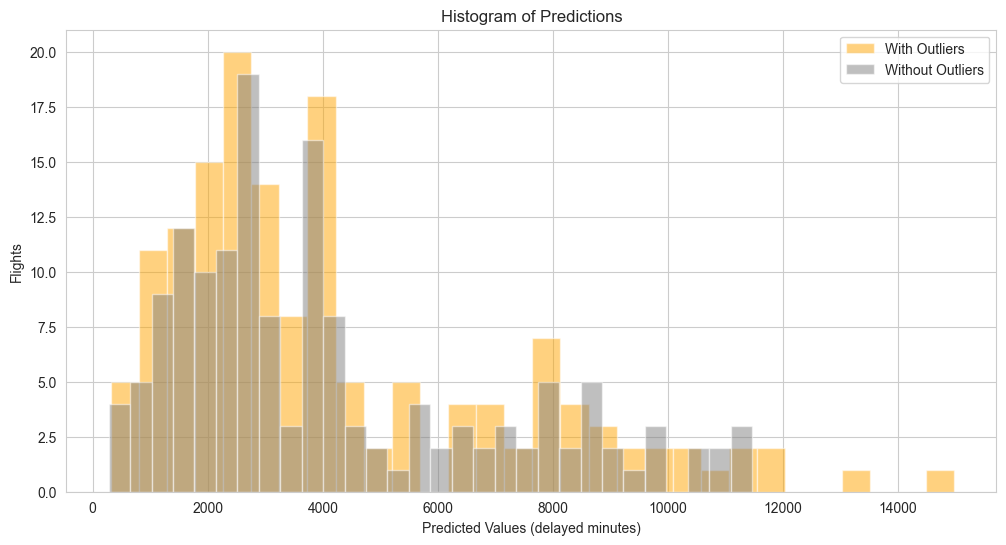

In [15]:
plt.figure(figsize=(12, 6))
plt.hist(predictions, bins=30, alpha=0.5, label='With Outliers', color='orange')
plt.hist(original_predictions_no_outliers, bins=30, alpha=0.5, label='Without Outliers', color='grey')
plt.title('Histogram of Predictions')
plt.xlabel('Predicted Values (delayed minutes)')
plt.ylabel('Flights')
plt.legend()
plt.show()

### **4. Pareto Front**

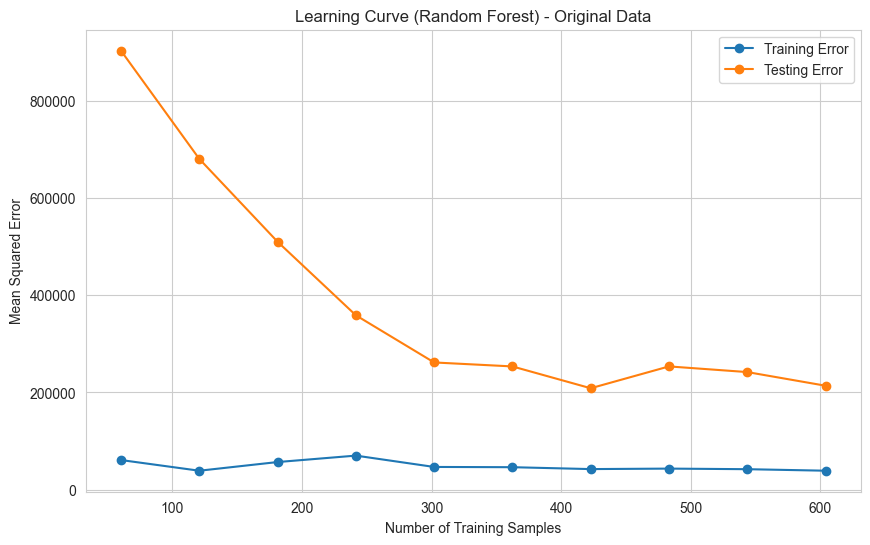

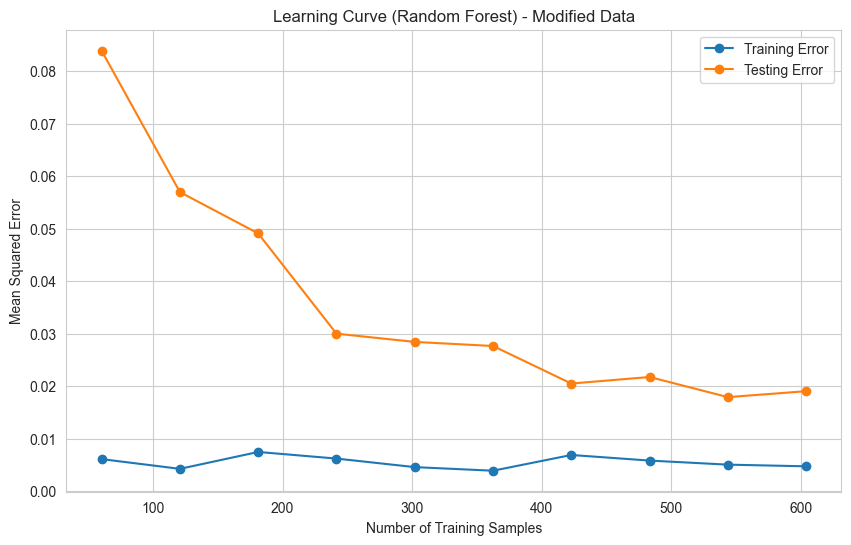

In [17]:
def plot_learning_curve(x_train, x_test, y_train, y_test, dataset_name):
    train_sizes = np.linspace(0.1, 1.0, 10)  # Use 10%, 20%, ..., 100% of the training data
    train_errors = []
    test_errors = []

    # Train the model with increasing data sizes and record the performance
    for train_size in train_sizes:
        # Subset the training data
        x_train_subset = x_train.sample(frac=train_size, random_state=42)
        y_train_subset = y_train.loc[x_train_subset.index]

        # Initialize the model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(x_train_subset, y_train_subset)
        
        # Calculate performance on the training set
        y_train_pred = model.predict(x_train_subset)
        train_mse = mean_squared_error(y_train_subset, y_train_pred)
        train_errors.append(train_mse)
        
        # Calculate performance on the fixed test set
        y_test_pred = model.predict(x_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_errors.append(test_mse)

    # Plotting the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * len(x_train), train_errors, label="Training Error", marker='o')
    plt.plot(train_sizes * len(x_train), test_errors, label="Testing Error", marker='o')
    plt.title(f"Learning Curve (Random Forest) - {dataset_name}")
    plt.xlabel("Number of Training Samples")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for the first dataset
plot_learning_curve(x_train, x_test, y_train, y_test, "Original Data")

# Plot for the second dataset
#plot_learning_curve(x_no_train, x_no_test, y_no_train, y_no_test, "Modified Data")

* **train_sizes**: Defines the proportion of the training set to use, from 10% up to 100%.
* **train_errors and test_errors**: They track the MSE for each subset of the data.
* **Learning Curve Plot**: It shows how the errors change as the model sees more data. If the test error continues to drop, it suggests that more data is beneficial.

Interpretation
* **High initial testing MSE followed by a decrease and plateau**: The model benefits from increased data up to a certain point, beyond which additional samples do not improve performance.
* **Low and constant training MSE**: The model is well-fitted to the training data, but the disparity between training and testing errors raises concerns about potential overfitting.